In [1]:
import boto3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

In [2]:
from datetime import datetime

In [3]:
import optuna
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, ClassifierMixin

C:\Users\mathe\OneDrive\Área de Trabalho\POS_TECH\bitcoin_model\.modelo\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from lightgbm import LGBMClassifier

In [5]:
import numpy as np

In [6]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [7]:
import yaml

In [8]:
from sklearn.metrics import roc_curve, roc_auc_score

# 0. Leitura dos Dados

In [9]:
config = yaml.safe_load(open('config_classifier.yaml', 'rb'))

In [10]:
config

{'bucket_name': 'fiap-projeto-math-refined',
 'parms': [{'colsample_bytree': 0.5,
   'learning_rate': 0.02,
   'max_depth': 8,
   'min_child_samples': 50,
   'n_estimators': 100,
   'num_leaves': 60,
   'random_state': 44,
   'subsample': 0.5,
   'verbose': 0}],
 'path_file_name': 'bitcoin/part-00000-a456c75c-7ccc-4db5-bd30-c4d135abc456-c000.snappy.parquet',
 'run_boruta': False,
 'run_optuna': False,
 'vars': ['return_1d',
  'close_zscore_7',
  'close_zscore_30',
  'open_zscore_60',
  'low_zscore_60',
  'price_high_to_ma_15',
  'price_open_to_ma_15',
  'Close',
  'Volume',
  'Close_prev']}

## 0.1 Extraindo Dados do S3

In [11]:
extract_table = False
if extract_table:
    client = boto3.client('s3')
    client.download_file(Bucket=config['bucket_name'], Key=config['path_file_name'], Filename='file.snappy.parquet')

## 0.2 Lendo os dados

In [12]:
df = pd.read_parquet('file.snappy.parquet')

In [13]:
pd.options.display.max_columns = None

# 1. Analise Exploratória de Dados

## 1.1 Verificando os Big Numbers do Bitcoin

### 1.1.1 Quantidade/Porcentagem de vezes que o Bitcoin subiu o valor

In [14]:
df.target.value_counts(normalize=True)

target
1    0.527549
0    0.472451
Name: proportion, dtype: float64

In [15]:
df.target.value_counts()

target
1    2049
0    1835
Name: count, dtype: int64

### 1.1.2 Quantidade de Linhas e Colunas

In [16]:
df.shape

(3884, 129)

### 1.1.3 Período disponível

In [17]:
print('Início: ', df['datetime'].min(), 'Fim: ',df['datetime'].max())

Início:  2014-09-17 00:00:00 Fim:  2025-05-05 00:00:00


### 1.1.4 Quantidade de dados por ano

In [18]:
df['ano'] = df['datetime'].apply(lambda row: row.strftime('%Y'))

In [19]:
df.groupby(['ano'])['ano'].count()

ano
2014    106
2015    365
2016    366
2017    365
2018    365
2019    365
2020    366
2021    365
2022    365
2023    365
2024    366
2025    125
Name: ano, dtype: int64

## 1.2 Valores máximos, mímimos e desvio padrão das variáveis principais (Abertura, Máxima, Fechamento)

In [20]:
print('Valores de Abertura (USD) \n Máximo: ', df['Open'].max(), '\n Mínimo: ', df['Open'].min(), '\n STD: ', df['Open'].std())

Valores de Abertura (USD) 
 Máximo:  106147.296875 
 Mínimo:  176.89700317382812 
 STD:  25238.767139155072


In [21]:
print('Valores de Máxima (USD) \n Máximo: ', df['High'].max(), '\n Mínimo: ', df['High'].min(), '\n STD: ', df['High'].std())

Valores de Máxima (USD) 
 Máximo:  109114.8828125 
 Mínimo:  211.7310028076172 
 STD:  25767.589774459495


In [22]:
print('Valores de Fechamento (USD) \n Máximo: ', df['Close'].max(), '\n Mínimo: ', df['Close'].min(), '\n STD: ', df['Close'].std())

Valores de Fechamento (USD) 
 Máximo:  106146.265625 
 Mínimo:  178.10299682617188 
 STD:  25262.206737797304


## 1.3 Crescimento do Volume

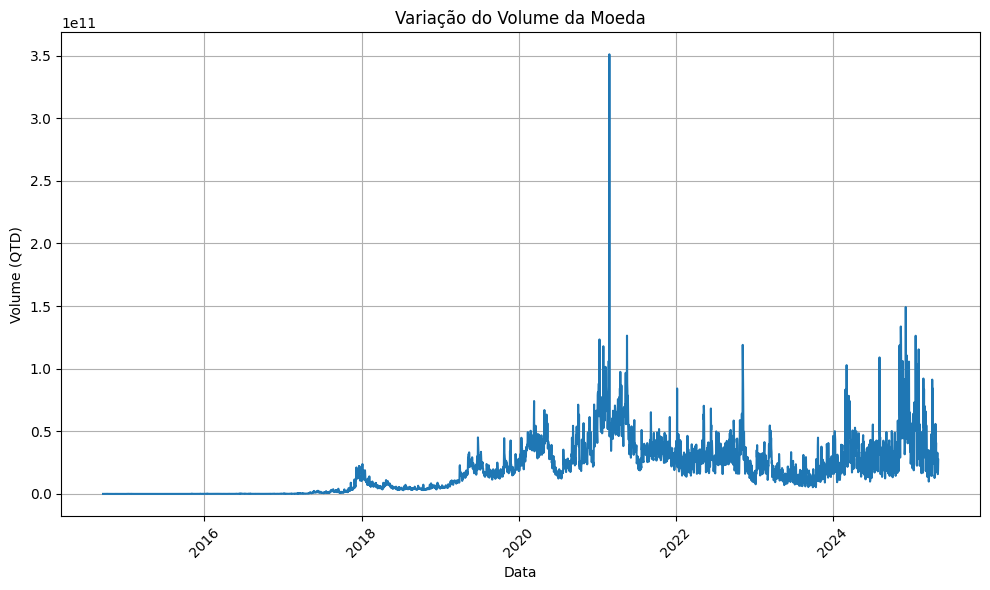

In [23]:
# Plot com Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="datetime", y="Volume")

plt.title("Variação do Volume da Moeda")
plt.xlabel("Data")
plt.ylabel("Volume (QTD)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 1.4 Crescimento do Valor (Fechamento)

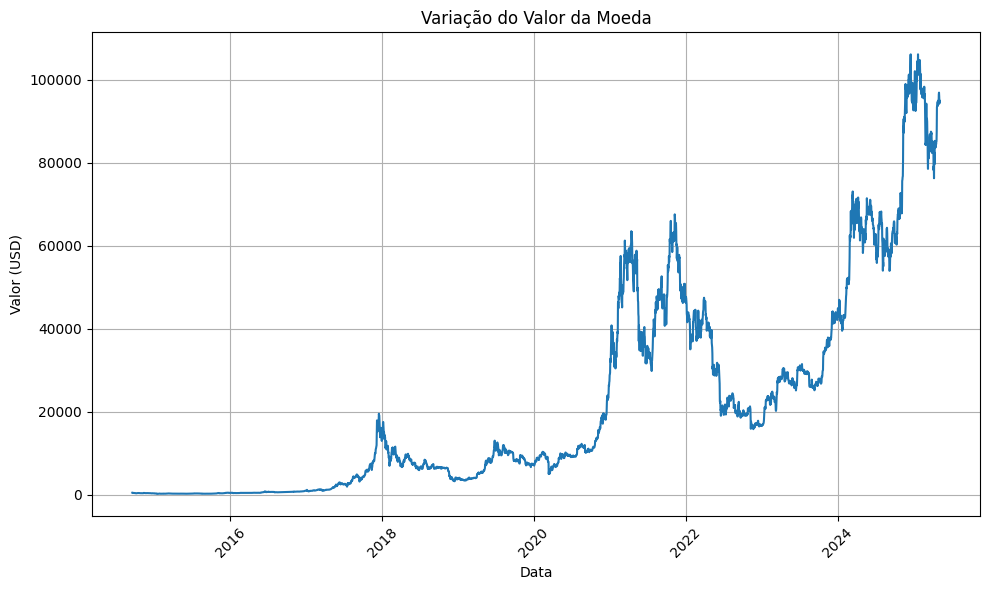

In [24]:
# Plot com Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="datetime", y="Close")

plt.title("Variação do Valor da Moeda")
plt.xlabel("Data")
plt.ylabel("Valor (USD)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 1.5 Crescimento do Market Cap

In [25]:
df['market_cap'] = df['Close']*df['Volume']

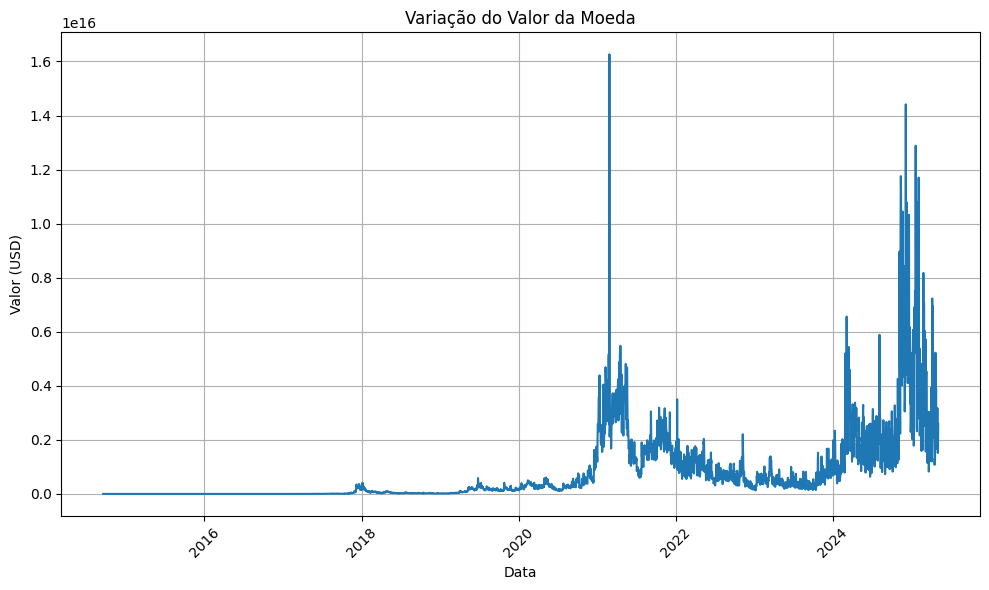

In [26]:
# Plot com Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="datetime", y="market_cap")

plt.title("Variação do Valor da Moeda")
plt.xlabel("Data")
plt.ylabel("Valor (USD)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 1.6 Boxplot da target pelo valor de fechamento

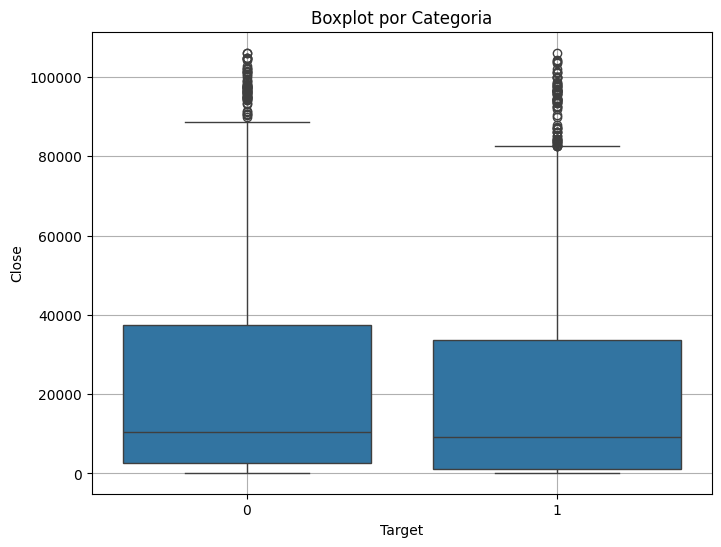

In [27]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="target", y="Close", data=df)

plt.title("Boxplot por Categoria")
plt.xlabel("Target")
plt.ylabel("Close")
plt.grid(True)
plt.show()